Based On Arshia Azfal's Code: Based Arshia Azfal's code: Training the Vision Transformer model to classify the intended upperlimb movement using discrete wavelet features. The dwt coefficients are simply concatenated as input feature to the transformer model. Preprocessing of the data using Etienne Montalivet's MNEFilter.

In [1]:
!pip install -q PyWavelets torch_geometric lightning wandb mne

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import torch
import numpy as np
import glob
import os
from tqdm import tqdm
import csv
import random
import h5py
import sys
import pywt

from torch.profiler import profile, record_function, ProfilerActivity

import torch.nn.functional as F
import scipy.io as sio

from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn import global_max_pool
from torch_geometric.data import Data
import lightning as L

from torch_geometric.loader import DataLoader

import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

import wandb

import matplotlib.pyplot as plt
import time

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

from torchmetrics.classification import MulticlassF1Score

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/INL')
from transform import MNEFilter
import mne

In [4]:
fs = 590 #Sampling frequency
n_ecogs = 31 #number of ecog channels
window_duration = 3 #seconds
num_classes = 6

In [5]:
y = np.load('/content/drive/MyDrive/Colab Notebooks/INL/processed_data/label2.npy')
X_train =  np.load('/content/drive/MyDrive/Colab Notebooks/INL/processed_data/X_train2.npy')


y_test = np.load('/content/drive/MyDrive/Colab Notebooks/INL/processed_data/label_test.npy')
X_test =  np.load('/content/drive/MyDrive/Colab Notebooks/INL/processed_data/X_test.npy')

In [6]:
X_train.shape

(11730, 31, 1770)

In [7]:
#Preprocess the data before reshaping for the Transformer
sfreq=fs
l_freq=1
h_freq=200
notch_freqs=[50, 100, 150, 200]
apply_car=True

mne_filter = MNEFilter(sfreq=sfreq, l_freq=l_freq, h_freq=h_freq, notch_freqs=notch_freqs, apply_car=apply_car)

In [8]:
filtered_data_train = []
filtered_data_test = []

mne.set_log_level("error")
for window in tqdm(X_train):
  filtered_window = mne_filter(window)
  filtered_data_train.append(filtered_window)

for window in tqdm(X_test):
  filtered_window = mne_filter(window)
  filtered_data_test.append(filtered_window)


#filtered_data_train = X_train
#filtered_data_test = X_test

100%|██████████| 2237/2237 [01:35<00:00, 23.52it/s]


In [9]:
print(len(filtered_data_train))
print(len(filtered_data_test))

11730
2237


In [10]:
np.array(filtered_data_train).shape

(11730, 31, 1770)

In [11]:
X_train = np.array(filtered_data_train).reshape(-1, n_ecogs * window_duration,fs)
X_test = np.array(filtered_data_test).reshape(-1,n_ecogs * window_duration,fs)

In [12]:
dataset = []

for idx in tqdm(range(X_train.shape[0])):
    eeg_clip = X_train[idx,:,:]
    label = y[idx]
    if label == 7 or label == 4: #ignore label 7, which produces weird results
        continue
    if label >= 5:
      label = label - 1 #Remap to remove wrist supination
    dataset.append((torch.tensor(eeg_clip).float(), torch.tensor((label), dtype=torch.long)))

random.shuffle(dataset)


dataset_test = []

for idx in tqdm(range(X_test.shape[0])):
    eeg_clip = X_test[idx,:,:]
    label = y_test[idx]
    if label == 7 or label == 4: #ignore label 7
        continue
    if label >= 5:
      label = label - 1 #Remap to remove wrist supination
    dataset_test.append( ( torch.tensor(eeg_clip).float(), torch.tensor((label) , dtype=torch.long) ) )

random.shuffle(dataset_test)

100%|██████████| 2237/2237 [00:00<00:00, 7531.16it/s]


In [13]:
train_dataloader = DataLoader(dataset , batch_size = 8, num_workers=11 )
test_dataloader = DataLoader(dataset_test , batch_size = 8, num_workers=11  )

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 11 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [14]:
import numpy as np

def upsample_wavelet_coeffs(coeffs, target_length):
    """
    Upsample or interpolate wavelet coefficients to the target length.

    Args:
        coeffs: List of arrays, each representing a level of wavelet coefficients.
        target_length: Desired length for each level.

    Returns:
        Array of shape (num_levels, target_length), where all levels are upsampled/interpolated.
    """
    upsampled_coeffs = []
    for level in coeffs:
        upsampled_level = np.interp(
            np.linspace(0, len(level) - 1, target_length),  # New indices
            np.arange(len(level)),                         # Original indices
            level                                          # Original values
        )
        upsampled_coeffs.append(upsampled_level)
    return np.array(upsampled_coeffs)


In [15]:
class AttentionBlock(nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        """Attention Block.

        Args:
            embed_dim: Dimensionality of input and attention feature vectors
            hidden_dim: Dimensionality of hidden layer in feed-forward network
                         (usually 2-4x larger than embed_dim)
            num_heads: Number of heads to use in the Multi-Head Attention block
            dropout: Amount of dropout to apply in the feed-forward network
        """
        super().__init__()


        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        inp_x = self.layer_norm_1(x)
        x = x + self.attn(inp_x, inp_x, inp_x)[0]
        x = x + self.linear(self.layer_norm_2(x))
        return x



class VisionTransformer(nn.Module):
    def __init__(
        self,
        embed_dim,
        hidden_dim,
        num_t_pints,
        num_heads,
        num_layers,
        num_classes,
        num_patches,
        num_scales,
        dropout=0.0,
        wavelet='db4',
        device = 'cpu'
    ):
        """Vision Transformer.

        Args:
            embed_dim: Dimensionality of the input feature vectors to the Transformer
            hidden_dim: Dimensionality of the hidden layer in the feed-forward networks
                         within the Transformer
            num_channels: Number of channels of the input (3 for RGB)
            num_heads: Number of heads to use in the Multi-Head Attention block
            num_layers: Number of layers to use in the Transformer
            num_classes: Number of classes to predict
            patch_size: Number of pixels that the patches have per dimension
            num_patches: Maximum number of patches an image can have
            dropout: Amount of dropout to apply in the feed-forward network and
                      on the input encoding
        """
        super().__init__()

        self.device = device

        #self.mne_filter = MNEFilter()

        self.input_layer = nn.Linear(num_t_pints  , embed_dim)
        self.transformer = nn.Sequential(
            *(AttentionBlock(embed_dim, hidden_dim, num_heads, dropout=dropout) for _ in range(num_layers))
        )
        self.mlp_head = nn.Sequential(nn.LayerNorm(embed_dim), nn.Linear(embed_dim, num_classes))
        self.dropout = nn.Dropout(dropout)

        # Parameters/Embeddings
        self.num_patches = num_patches
        self.num_scales = num_scales
        self.num_t_pints = num_t_pints
        self.wavelet = wavelet
        self.embed_dim = embed_dim
        self.cls_token = nn.Parameter(torch.randn(1, 1, self.embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1, 1 + self.num_patches * (self.num_scales + 1), self.embed_dim))
        self.scales = np.arange(1, num_scales + 1)


    def forward(self, x):

        # Perform DWT
        wavelet_features = []
        #print(f"Shape of x: {x.shape}")
        for batch in x:
          batch_features = []
          for channel in batch:
            coeffs = pywt.wavedec(channel.cpu().numpy(), self.wavelet, level=self.num_scales)  # Decompose signal into 4 levels


            upsampled_coeffs = upsample_wavelet_coeffs(coeffs, target_length=self.num_t_pints)
            #print(f"Shape of upsampled_coeffs: {upsampled_coeffs.shape}")

            batch_features.append(torch.tensor(upsampled_coeffs, dtype=torch.float32).to(self.device))
          wavelet_features.append(torch.stack(batch_features))  # (n_channels, n_scales, n_samples)
        #print(f"Shape of batch stack: {torch.stack(batch_features).shape}")
        wavelet_features = torch.stack(wavelet_features) # (n_batches, n_channels, n_scales, n_samples)
        #print(wavelet_features.shape)

        B, C, S, T = wavelet_features.shape
        x = wavelet_features.view(B, C * S, T)
        x = (x - x.mean(dim=-1 , keepdim=True) )/x.std(dim=-1 , keepdim=True)

        #B, T, _ = x.shape # B Batch, T Timepoints

        x = self.input_layer(x)

        # Add CLS token and positional encoding
        cls_token = self.cls_token.repeat(B, 1, 1)
        x = torch.cat([cls_token, x], dim=1)
        #print(f"x.shape : {x.shape} ")
        #print(f"self.pos_embedding.shape : {self.pos_embedding.shape} ")
        x = x + self.pos_embedding[:, : T + 1]

        # Apply Transforrmer
        x = self.dropout(x)
        x = x.transpose(0, 1)
        x = self.transformer(x)

        # Perform classification prediction
        cls = x[0]
        out = self.mlp_head(cls)
        return out




class ViT(L.LightningModule):
    def __init__(self, model_kwargs):
        super().__init__()

        self.model = VisionTransformer(**model_kwargs)


    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):

        optimizer = optim.Adam(params=self.parameters(), lr = 1e-3)

        scheduler = CosineAnnealingLR(optimizer, T_max = 50)

        return [optimizer], [{"scheduler": scheduler, "interval": "epoch"}]


    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs)
        loss = F.cross_entropy(preds, labels)

        #wandb.log({ "Bridge-GPT-Loss": loss})

        return loss

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [17]:
"""
model_kwargs={
        "embed_dim": 64,
        "hidden_dim": 64,
        "num_heads": 8,
        "num_layers": 4,
        "num_t_pints": 590,
        "num_patches": 93,
        "num_classes": 7,
        "num_scales": 128,
        "dropout": 0.2,
    }
"""

model_kwargs={
        "embed_dim": 16,
        "hidden_dim": 32,
        "num_heads": 4,
        "num_layers": 4,
        "num_t_pints": 590,
        "num_patches": 93,
        "num_classes": num_classes,
        "num_scales": 4,
        "dropout": 0.2,
        "wavelet": "db4",
        "device" : device
    }

model = ViT(model_kwargs)

In [18]:
trainer = L.Trainer(max_epochs= 50 , devices= 1, accelerator=device)

trainer.fit(model, train_dataloader)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | VisionTransformer | 26.0 K | train
----------------------------------------------------
26.0 K    Trainable params
0         Non-trainable params
26.0 K    Total params
0.104     Total estimated model params size (MB)
51        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | VisionTransformer | 26.0 K | train
------------------------------------

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


In [19]:
import pytorch_lightning

torch.seed()
np.random.seed(120)
random.seed(123)
pytorch_lightning.utilities.seed

model.to(device)
l = [] #labels
gt = [] #ground thruth

for data in (tqdm(test_dataloader)):

    out = model(data[0].to(device))

    l.extend(out.to('cpu').detach().numpy())

    gt.extend(( data[1].type(torch.float32).reshape(-1,1).to('cpu') ).detach().numpy())

  0%|          | 0/278 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 11 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 278/278 [00:59<00:00,  4.70it/s]


In [24]:
from torchmetrics.classification import MulticlassConfusionMatrix

target = torch.tensor( np.array(gt).reshape(-1,) )
label =   torch.squeeze( torch.tensor( np.array(l)) )

metric = MulticlassConfusionMatrix(num_classes=num_classes)

c = np.array(metric(torch.argmax(label,-1) , target))

In [25]:
label_dict = {0: 'state__idle',
           1: 'state__shoulder__flexion',
           2: 'state__elbow__extension',
           3: 'state__wrist__pronation',
           4: 'state__hand__open',
           5: 'state__hand__close',
          }

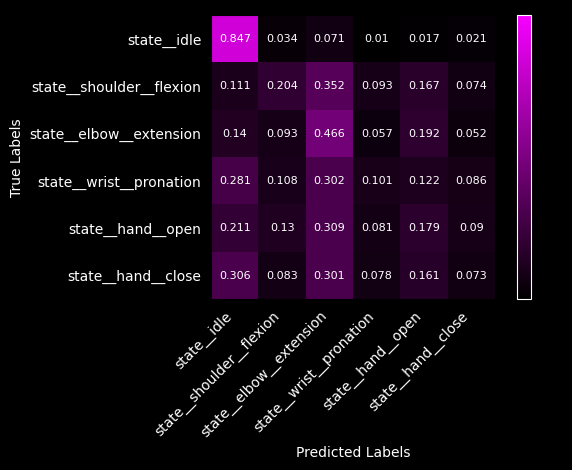

In [26]:
# import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

C = c

colors = ['k' , '#F601FF'] # first color is black, last is red
cm = LinearSegmentedColormap.from_list(
        "Custom", colors, N=200)

class_labels = [0, 1, 2, 3, 4, 5]

normalized_confusion_matrix =  np.round(C/ np.sum(C, axis=1, keepdims=True), 3)

fig, ax = plt.subplots(facecolor='k')
im = ax.imshow(normalized_confusion_matrix , cmap = cm , vmin=0, vmax=1)
cb = fig.colorbar(im , ax=ax)
cb.outline.set_edgecolor('w')

ax.set_xlabel("Predicted Labels", color='w')
ax.set_ylabel("True Labels", color='w')

ax.set_xticks(np.arange(len(class_labels)), labels=[name for _, name in  label_dict.items()], color='w', rotation=45, ha='right')
ax.set_yticks(np.arange(len(class_labels)), labels=[name for _, name in  label_dict.items()], color='w')




for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        text = ax.text(j, i, normalized_confusion_matrix[i, j],
                        ha="center", va="center", color="w" , size=8)


fig.tight_layout()
plt.show()

In [27]:
diagonal_avg = np.mean(np.diag(normalized_confusion_matrix))
print("Diagonal Average of Confusion Matrix:", diagonal_avg)

# Initialize the F1 metric (macro-average)
f1_metric = MulticlassF1Score(num_classes=num_classes, average='macro')

# Compute the F1 score
f1_score = f1_metric(torch.argmax(label,-1) , target)
print("Macro-Averaged F1-Score:", f1_score.item())

Diagonal Average of Confusion Matrix: 0.31166666666666665
Macro-Averaged F1-Score: 0.28799107670783997
